# Dataset Generation - Part 1

The primary objective of this repository is to create a dialogue dataset, with a focus on generating interactions that explore join combinations. By identifying that table A can be joined with table C, and table C can be joined with table D, we can create dialogues that request information connecting various table combinations such as A to B, A to C, and so forth.

To achieve this, we will need to identify all possible join combinations within our MONDIAL schema, ensuring:

1. Complete coverage of all tables in the schema
2. Equitable representation across all tables
3. Balanced distribution of join types (where each join combination corresponds to one interaction, allowing for multiple interactions per dialogue. We aim to maintain approximately equal quantities of different join types, such as 2-way, 3-way, and 4-way joins).

In [1]:
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Visualization config
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

# Environment variables loading - return True if the file is loaded
load_dotenv()

True

# Join Finder (using LLM)

As o3-mini model from OpenAI have strong reasoning capabilities and enought context window to accept our full schema. I'll prompt to the model asking for him to find the available joins in our schema. 

I'll also use pydantic to setup the output format, joins will have the following output:

In [2]:
from llm_config import LLMConfig
from pydantic import BaseModel, Field
from typing import List

join_finder_llm = LLMConfig(provider="azure").get_llm(model="o3-mini", reasoning_effort="high")

# Join structure
class Join(BaseModel):
    from_: str = Field(..., alias="from", description="Origin table of the join")

    to: str = Field(..., description="Destiny table of the join")

    on: List[str] = Field(..., description="Fully qualified join conditions in the format \
                          'TABLE1.COLUMN1=TABLE2.COLUMN2'")
    
# Output Structure (list of joins)
class FirstStepOutputFormat(BaseModel):
    joins: List[Join] = Field(..., description="List of possible joins between tables")
    

join_finder_llm_with_structured_output = join_finder_llm.with_structured_output(FirstStepOutputFormat)


In [3]:
def find_joins(schema):    
    join_finder_prompt = """
Given the schema of the Mondial database, generate all possible join combinations between tables. 
Use PK and FK informations for that, and consider that the tables are connected by a single join.

Be very careful with composed keys, they are a combination of two or more columns that are used to 
reference another table.

For each join condition, use the fully qualified column name format: 'TABLE1.COLUMN1=TABLE2.COLUMN2'

Examples of the required format:
- For a simple join: 
  Join(from_='MONDIAL_AIRPORT', to='MONDIAL_COUNTRY', on=['MONDIAL_COUNTRY.CODE=MONDIAL_AIRPORT.COUNTRY'])

- For a composed key join:
  Join(from_='MONDIAL_CITYOTHERNAME', to='MONDIAL_CITY', on=['MONDIAL_CITYOTHERNAME.CITY=MONDIAL_CITY.NAME',
    'MONDIAL_CITYOTHERNAME.COUNTRY=MONDIAL_CITY.COUNTRY', 'MONDIAL_CITYOTHERNAME.PROVINCE=MONDIAL_CITY.PROVINCE'])

Schema:
{schema}

BE CAREFUL TO NOT MISS ANY JOIN, AND DON'T CREATE A JOIN THAT DOESN'T EXIST IN THE SCHEMA. ALSO DON'T FORGET ANY TABLE IN THE SCHEMA.

Structured Output:
"""

    prompt_with_schema = join_finder_prompt.format(schema=schema)

    structured_output = join_finder_llm_with_structured_output.invoke(prompt_with_schema)
    joins = structured_output.joins

    # Exibir os primeiros 5 joins para validação
    for i, join in enumerate(joins[:5]):
        print(f"Join {i+1}: {join.from_} → {join.to} ON {', '.join(join.on)}")

    return joins

## Now that we have the function that will prompt to LLM the schema and return the join combinations, we'll read the schema from .txt file and find the joins

In [7]:
with open("mondial/schema.txt", "r") as f:
    schema = f.read()

joins = find_joins(schema)

# We print 5 examples, but have a lot of joins.
print("Was generated {} joins.".format(len(joins)))

Join 1: MONDIAL_AIRPORT → MONDIAL_COUNTRY ON MONDIAL_COUNTRY.CODE=MONDIAL_AIRPORT.COUNTRY
Join 2: MONDIAL_AIRPORT → MONDIAL_CITY ON MONDIAL_CITY.NAME=MONDIAL_AIRPORT.CITY, MONDIAL_CITY.COUNTRY=MONDIAL_AIRPORT.COUNTRY, MONDIAL_CITY.PROVINCE=MONDIAL_AIRPORT.PROVINCE
Join 3: MONDIAL_CITYOTHERNAME → MONDIAL_CITY ON MONDIAL_CITYOTHERNAME.CITY=MONDIAL_CITY.NAME, MONDIAL_CITYOTHERNAME.COUNTRY=MONDIAL_CITY.COUNTRY, MONDIAL_CITYOTHERNAME.PROVINCE=MONDIAL_CITY.PROVINCE
Join 4: MONDIAL_CITYPOPS → MONDIAL_CITY ON MONDIAL_CITYPOPS.CITY=MONDIAL_CITY.NAME, MONDIAL_CITYPOPS.COUNTRY=MONDIAL_CITY.COUNTRY, MONDIAL_CITYPOPS.PROVINCE=MONDIAL_CITY.PROVINCE
Join 5: MONDIAL_LOCATEDON → MONDIAL_CITY ON MONDIAL_LOCATEDON.CITY=MONDIAL_CITY.NAME, MONDIAL_LOCATEDON.COUNTRY=MONDIAL_CITY.COUNTRY, MONDIAL_LOCATEDON.PROVINCE=MONDIAL_CITY.PROVINCE
Was generated 46 joins.


# Now we need to also get the information from the schema and put in some datastructures:

1. Hashmap to retrieve a table DDL clause by table name as key
2. Hashmap to retrieve a table DDL clause by column name as keyq

In [8]:
import re

def extract_tables_and_columns(schema_text):
    
    # !!! This is a very specific pattern to extract the table DDLs and columns from our schema.
    # !!! It's not a general purpose functio, you may change that for your use case.
    pattern = re.compile(
        r"--\s*auto-generated definition\s*\n(.*?)(?=(--\s*auto-generated definition)|\Z)",
        re.DOTALL | re.IGNORECASE
    )
    
    matches = pattern.findall(schema_text)
    table_ddls = {}
    table_columns = {}
    
    for block, _ in matches:
        
        table_name_match = re.search(r"create table\s+([A-Z0-9_]+)", block, re.IGNORECASE)
        if table_name_match:
            table_name = table_name_match.group(1)
            ddl_text = block.strip()
            table_ddls[table_name] = ddl_text
            
            
            column_pattern = re.compile(r"^\s*([A-Z0-9_]+)\s+[A-Z0-9_]+", re.MULTILINE)
            columns = column_pattern.findall(block)
            table_columns[table_name] = columns
    
    return table_ddls, table_columns

table_ddls, table_columns = extract_tables_and_columns(schema)

total_tables = len(table_ddls)
total_columns = sum(len(cols) for cols in table_columns.values())

print(f"Total tables in schema: {total_tables}")
print(f"Total columns in schema: {total_columns}")

Total tables in schema: 40
Total columns in schema: 209


# Creating join algorithm to find optimal join combinations

## Join Generation Algorithm for Balanced Schema Representation

This algorithm generates an optimized set of joins to represent a database schema, prioritizing:

1. Complete coverage (100%) of all tables in the schema
2. Balance between join types (double, triple, and quadruple joins)
3. Equitable distribution of table frequency
4. Minimization of redundancy between combinations

## Algorithm Strategy

### Overview

1. Determine the ideal set of combinations:
   - Test different quantities of combinations
   - For each quantity, generate combinations balancing types
   - Evaluate each generated set according to our metrics
   - Select the set that best meets the criteria

2. For each candidate set:
   - Phase 1: Achieve complete table coverage
   - Phase 2: Refine to ensure balance between types
   - Calculate balance and quality metrics

### Balanced Combination Generation

```python
def generate_balanced_combinations(joins, all_tables, n):
    # 1. Initialize structures to track covered tables and frequencies
    
    # 2. PHASE 1 - ENSURE COVERAGE:
    while coverage < 100% and total_combinations < n:
        # a. Identify under-represented join type (2, 3, or 4)
        # b. Select combination of that type maximizing new table coverage
        # c. If no useful combination of priority type, be flexible
        # d. Add combination to set and update statistics
    
    # 3. PHASE 2 - BALANCE TYPES:
    while total_combinations < n:
        # a. Identify join type furthest from target (n/3)
        # b. Select combination favoring under-represented tables
        # c. If no viable option of that type, try other types
        # d. Add combination and update statistics
    
    # 4. Return final set of combinations and metrics
```

## Evaluation and Selection

```python
def find_optimal_set(joins, all_tables, min_n, max_n, step):
    # 1. For each size n between min_n and max_n:
    for n in range(min_n, max_n + 1, step):
        # a. Generate set with n balanced combinations
        # b. Calculate metrics:
        #    - Table coverage (%)
        #    - Deviation from ideal type distribution
        #    - Ratio between most/least frequent types
        #    - Coefficient of variation for table frequency
    
    # 2. Filter sets with 100% coverage
    
    # 3. Select set with best type balance
    #    (smallest deviation from ideal n/3 per type)
    
    # 4. Visualize results and return optimal set
```

Graph built with 40 tables and 44 possible joins
Total of tables in the schema: 40


/var/folders/kx/_rp_q3l95vv5m3m9dth8j6400000gn/T/ipykernel_35346/3521523146.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


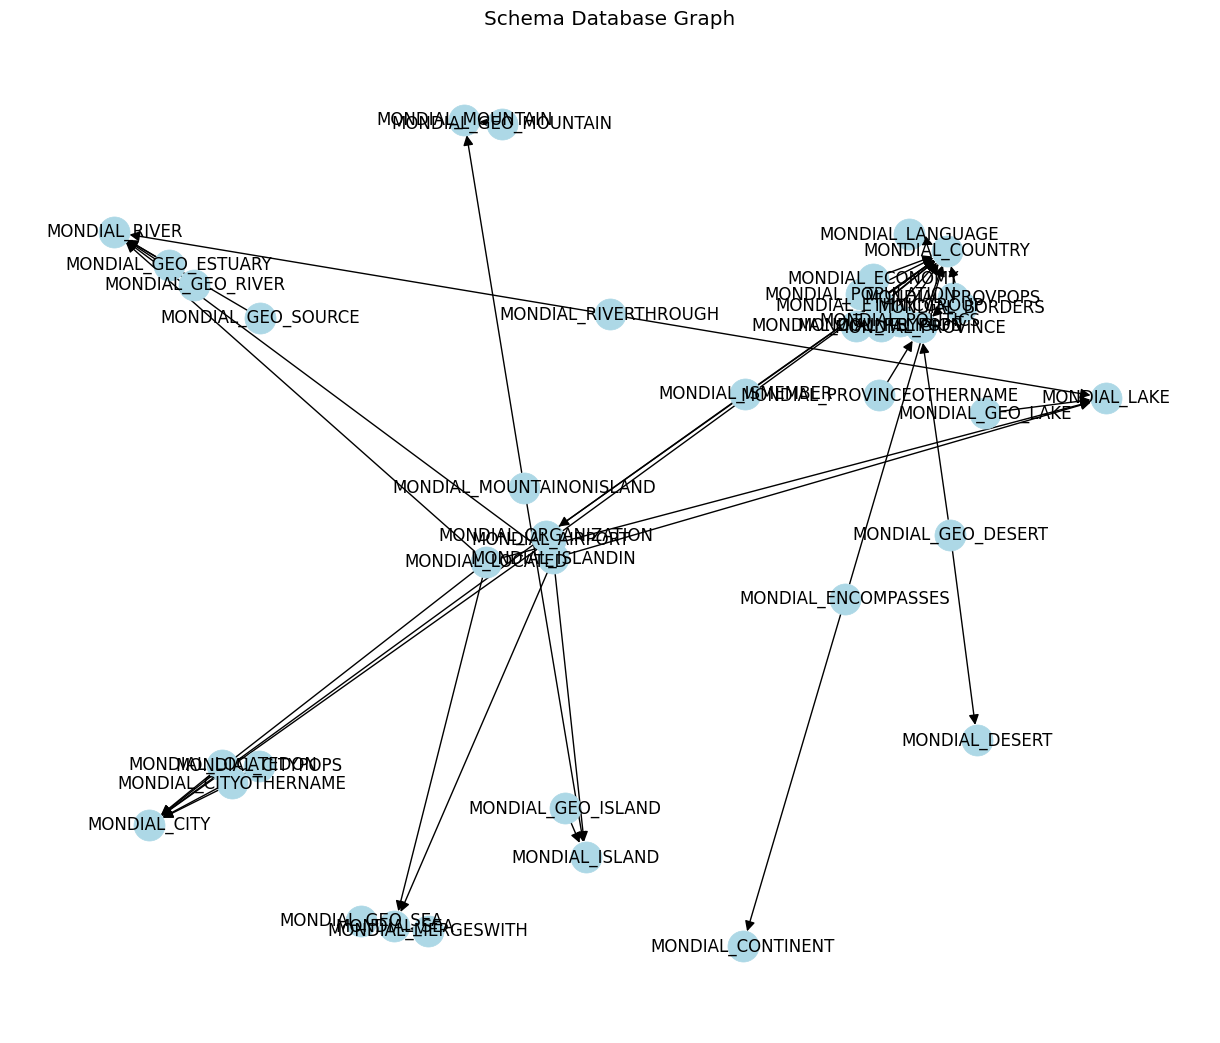

In [ ]:
# First we need to build the schema graph to visualize the schema

import networkx as nx
import matplotlib.pyplot as plt

def build_schema_graph(joins):
    """
    Build a graph to visualize the schema
    - Nodes: tables
    - Edges: joins between tables
    """
    G = nx.DiGraph()
    
    # Add all tables as nodes
    for join in joins:
        G.add_node(join.from_)
        G.add_node(join.to)
        # Add directional edge with join details
        G.add_edge(join.from_, join.to, conditions=join.on, join_obj=join)
    
    print(f"Graph built with {G.number_of_nodes()} tables and {G.number_of_edges()} possible joins")
    
    return G

# Build the schema graph
schema_graph = build_schema_graph(joins)

# Check all tables in the graph
all_tables = list(schema_graph.nodes())
print(f"Total of tables in the schema: {len(all_tables)}")

# Visualize the graph (optional, can be commented if the graph is too large)
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(schema_graph, seed=42)  # Positioning for visualization
nx.draw(schema_graph, pos, with_labels=True, node_color='lightblue', 
        node_size=500, arrows=True, arrowsize=15)
plt.title("Schema Database Graph")
plt.tight_layout()
plt.show()

In [11]:
# Second step we need to create our join combinations for each type of join
# We need to ensure that the combinations are connected, because we want to generate dialogues that 
# connect the tables in a logical way.
import itertools

def is_connected_subgraph(join_set):
    """
    Check if the set of joins forms a connected subgraph (undirected).
    """
    if not join_set:
        return False
    
    # For 1 join only, we consider connected
    if len(join_set) == 1:
        return True
    
    tables = set()
    for j in join_set:
        tables.add(j.from_)
        tables.add(j.to)
    
    # We build an undirected graph
    graph = {t: set() for t in tables}
    for j in join_set:
        graph[j.from_].add(j.to)
        graph[j.to].add(j.from_)
    
    visited = set()
    queue = [next(iter(tables))]
    visited.add(queue[0])
    
    while queue:
        node = queue.pop(0)
        for neighbor in graph[node]:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
    
    return len(visited) == len(tables)

def prepare_all_combinations(joins, max_size=4):
    """
    Generate all possible combinations of 2, 3, 4 joins that are connected.
    Returns { '2': [...], '3': [...], '4': [...] }.
    """
    combos_by_type = {"2": [], "3": [], "4": []}
    for size in [2, 3, 4]:
        if size > max_size:
            continue
        all_subsets = list(itertools.combinations(joins, size))
        valid = []
        for sset in all_subsets:
            if is_connected_subgraph(sset):
                valid.append(sset)
        combos_by_type[str(size)] = valid
    return combos_by_type

In [12]:
# Now we need to select the best combinations for each type of join
# We need to ensure that the combinations are balanced, and that we have a good coverage of the schema.

def get_join_type(comb):
    """
    Returns '2','3','4' based on the number of distinct tables in 'comb'.
    """
    tables = set()
    for j in comb:
        tables.add(j.from_)
        tables.add(j.to)
    tcount = len(tables)
    if tcount <= 2:
        return "2"
    elif tcount == 3:
        return "3"
    else:
        return "4"

def is_redundant(new_comb, existing_list, threshold=0.75):
    """
    Says if new_comb is redundant compared to 'existing_list' of combos,
    if the overlap of tables >= threshold.
    """
    new_tables = set()
    for j in new_comb:
        new_tables.add(j.from_)
        new_tables.add(j.to)
    
    for comb in existing_list:
        c_tables = set()
        for jj in comb:
            c_tables.add(jj.from_)
            c_tables.add(jj.to)
        inter = len(new_tables.intersection(c_tables))
        uni = len(new_tables.union(c_tables))
        if uni == 0:
            continue
        if (inter/uni) >= threshold:
            return True
    return False

def select_balanced_combinations(
    combos_by_type, 
    all_tables, 
    min_n=30, 
    coverage_first=True
    ):
    """
    Select combinations, prioritizing:
    1) 100% coverage if coverage_first = True
    2) Balance of types (2,3,4)
    3) Achieve at least min_n combinations
    4) Table frequency (with lower weight)
    
    combos_by_type: dictionary { '2': [...], '3': [...], '4': [...] } 
    """
    selected = {"2": [], "3": [], "4": []}
    table_freq = {t: 0 for t in all_tables}
    tables_covered = set()
    
    def coverage_percent():
        return (len(tables_covered)/len(all_tables)) * 100.0
    
    def count_total():
        return sum(len(selected[t]) for t in ["2","3","4"])
    
    # Define score for combo
    def combo_score(comb):
        c_tables = set()
        for j in comb:
            c_tables.add(j.from_)
            c_tables.add(j.to)
        
        # Prioritize adding new tables if coverage < 100
        new_tables = 0
        freq_penalty = 0
        for tab in c_tables:
            if tab not in tables_covered:
                new_tables += 1
            else:
                # penalize a bit tables that are already very frequent
                if table_freq[tab] > 2:
                    freq_penalty += (table_freq[tab] - 2)**2
        
        # Final score
        return new_tables*20 - freq_penalty
    
    # Phase 1: Coverage, if coverage_first
    coverage_done = (coverage_percent() >= 100.0)
    iters_no_progress = 0
    max_iters = 50
    
    while (coverage_first and not coverage_done) and iters_no_progress < max_iters:
        best_c = None
        best_type = None
        best_s = float('-inf')
        
        for t in ["2","3","4"]:
            for comb in combos_by_type[t]:
                if comb in selected[t]:
                    continue
                if is_redundant(comb, selected[t]):
                    continue
                sc = combo_score(comb)
                if sc > best_s:
                    best_s = sc
                    best_c = comb
                    best_type = t
        
        if best_c is None:
            iters_no_progress += 1
        else:
            selected[best_type].append(best_c)
            c_tables = set()
            for j in best_c:
                c_tables.add(j.from_)
                c_tables.add(j.to)
            for tab in c_tables:
                table_freq[tab]+=1
                tables_covered.add(tab)
            iters_no_progress = 0
        
        coverage_done = (coverage_percent() >= 100.0)
    
    if coverage_done:
        print(f"[Coverage] Achieved 100% coverage with {count_total()} combos.")
    else:
        print(f"[Coverage] Could not reach 100%. Current: {coverage_percent():.2f}%")
    
    # Phase 2: Balance of types and min_n
    attempts_no_improv = 0
    while count_total() < min_n and attempts_no_improv < 30:
        # Identify the under-represented type
        type_counts = {t: len(selected[t]) for t in ["2","3","4"]}
        total_c = sum(type_counts.values())
        if total_c == 0:
            # if there is nothing yet, prioritize 2
            sub_type = "2"
        else:
            sub_type = min(type_counts, key=type_counts.get)
        
        best_c = None
        best_score_ = float('-inf')
        
        for comb in combos_by_type[sub_type]:
            if comb in selected[sub_type]:
                continue
            if is_redundant(comb, selected[sub_type]):
                continue
            sc = combo_score(comb)
            if sc > best_score_:
                best_score_ = sc
                best_c = comb
        
        if best_c is None:
            # try another type
            found_something = False
            for alt_type in ["2","3","4"]:
                if alt_type == sub_type:
                    continue
                alt_best = None
                alt_bs = float('-inf')
                for comb in combos_by_type[alt_type]:
                    if comb in selected[alt_type]:
                        continue
                    if is_redundant(comb, selected[alt_type]):
                        continue
                    sc = combo_score(comb)
                    if sc> alt_bs:
                        alt_bs= sc
                        alt_best= comb
                if alt_best:
                    selected[alt_type].append(alt_best)
                    c_tables = set()
                    for j in alt_best:
                        c_tables.add(j.from_)
                        c_tables.add(j.to)
                    for tb in c_tables:
                        table_freq[tb]+=1
                        tables_covered.add(tb)
                    found_something = True
                    break
            if not found_something:
                attempts_no_improv+=1
        else:
            selected[sub_type].append(best_c)
            c_tables = set()
            for j in best_c:
                c_tables.add(j.from_)
                c_tables.add(j.to)
            for tb in c_tables:
                table_freq[tb]+=1
                tables_covered.add(tb)
            attempts_no_improv= 0
    
    return selected, table_freq, tables_covered

In [13]:
# Now we want to define functions to plot information about the combinations that we are creating

def summarize_and_plot_results(selected, table_freq, all_tables):
    """
    Shows:
      - Frequency of each table (histogram with mean and median)
      - Distribution of types (bars)
    """
    type_counts = {t: len(selected[t]) for t in ["2","3","4"]}
    total_combos = sum(type_counts.values())
    
    print("\n=== Final Results ===")
    print(f"Total combos: {total_combos}")
    for t in ["2","3","4"]:
        print(f" Type {t}: {type_counts[t]} combos")
    
    used_tables = [t for t, f in table_freq.items() if f>0]
    coverage= len(used_tables)/len(all_tables)*100
    print(f"Coverage: {coverage:.2f}%  | {len(used_tables)}/{len(all_tables)} tables used.\n")
    
    freq_values= list(table_freq.values())
    mean_f= np.mean(freq_values) if freq_values else 0
    median_f= statistics.median(freq_values) if freq_values else 0
    
    print(f"Mean frequency: {mean_f:.2f}")
    print(f"Median frequency: {median_f:.2f}")
    
    # Graph 1: Histogram of frequency
    plt.figure(figsize=(12,5))
    if freq_values:
        max_f= max(freq_values)
        bins= range(0, max_f+2)
        plt.hist(freq_values, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(x=mean_f, color='red', linestyle='--', label=f'Mean: {mean_f:.2f}')
        plt.axvline(x=median_f, color='green', linestyle=':', label=f'Median: {median_f:.2f}')
    plt.title("Table Frequency Distribution")
    plt.xlabel("Frequency of Appearance")
    plt.ylabel("Number of Tables")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()
    
    # Graph 2: Distribution by type
    plt.figure(figsize=(6,4))
    sizes= ["2","3","4"]
    counts= [type_counts[s] for s in sizes]
    
    bars= plt.bar(sizes, counts, color=['lightblue','lightgreen','salmon'])
    for i, c in enumerate(counts):
        plt.text(i, c+0.1, str(c), ha='center', va='bottom', fontweight='bold')
    
    plt.title("Distribution of Join Types in Final Selection")
    plt.xlabel("Join Size")
    plt.ylabel("Quantity")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

import numpy as np
import statistics
import matplotlib.pyplot as plt

def plot_all_table_frequencies(table_freq, title="Frequency of All Tables in Combinations"):
    """
        Gera um gráfico de barras mostrando a frequência de cada tabela.
        As tabelas são ordenadas em ordem decrescente de frequência.
        Adiciona linhas horizontais indicando média e mediana.
    
    Args:
        table_freq (dict): dictionary {table_name: frequency_occurrence}
        title (str): title of the graph (optional)
    """
    
    # 1. Sort tables by frequency (descending)
    sorted_items = sorted(table_freq.items(), key=lambda x: x[1], reverse=True)
    table_names = [item[0] for item in sorted_items]
    frequencies = [item[1] for item in sorted_items]
    
    # 2. Calculate mean and median (if the list is empty, we define 0)
    if frequencies:
        mean_freq = np.mean(frequencies)
        median_freq = statistics.median(frequencies)
    else:
        mean_freq, median_freq = 0, 0
    
    # 3. Create figure and plot bars
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(table_names)), frequencies, color='skyblue', edgecolor='black')
    
    # 4. Horizontal lines: mean (red) and median (green)
    plt.axhline(y=mean_freq, color='red', linestyle='--', label=f'Mean: {mean_freq:.2f}')
    plt.axhline(y=median_freq, color='green', linestyle='--', label=f'Median: {median_freq:.2f}')
    
    # 5. Labels and styling
    plt.title(title)
    plt.xlabel("Table")
    plt.ylabel("Number of occurrences")
    plt.xticks(range(len(table_names)), table_names, rotation=90)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()  # Adjusts spacing to not cut legends
    
    # Show or save
    plt.show()

# Example of use (in another cell or at the end of the code):
# plot_all_table_frequencies(table_freq, "Frequency of All Tables in the Optimal Set")

def save_optimal_join_combinations(selected, output_path='mondial/optimal_join_combinations.csv'):
    """
    Saves the optimal join combinations to a CSV file.
    
    Args:
        selected (dict): Dictionary with keys '2', '3', '4' mapping to lists of join combinations
        output_path (str): Path where the CSV file will be saved
    """
    import pandas as pd
    
    # Create lists to store data
    types = []
    combination_ids = []
    tables_list = []
    join_conditions = []
    
    # For each type of join (2, 3, 4)
    for join_type in ["2", "3", "4"]:
        # For each combination in that type
        for i, combo in enumerate(selected[join_type], 1):
            # Get all unique tables in this combination
            tables = set()
            for join in combo:
                tables.add(join.from_)
                tables.add(join.to)
            
            # Format join conditions
            conditions = []
            for join in combo:
                if hasattr(join, 'on') and join.on:
                    conditions.append(f"{join.from_}.{join.on}")
                else:
                    conditions.append(f"{join.from_} → {join.to} (incomplete condition)")
            
            # Add to our lists
            types.append(int(join_type))
            combination_ids.append(i)
            tables_list.append(", ".join(sorted(tables)))
            join_conditions.append("; ".join(conditions))
    
    # Create DataFrame
    df = pd.DataFrame({
        'Type': types,
        'Combination': combination_ids,
        'Tables': tables_list,
        'Join Conditions': join_conditions
    })
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"Saved optimal join combinations to {output_path}")

Graph built with 40 tables and 44 possible joins
[Coverage] Achieved 100% coverage with 11 combos.

=== Final Results ===
Total combos: 50
 Type 2: 17 combos
 Type 3: 17 combos
 Type 4: 16 combos
Coverage: 100.00%  | 40/40 tables used.

Mean frequency: 4.83
Median frequency: 5.00


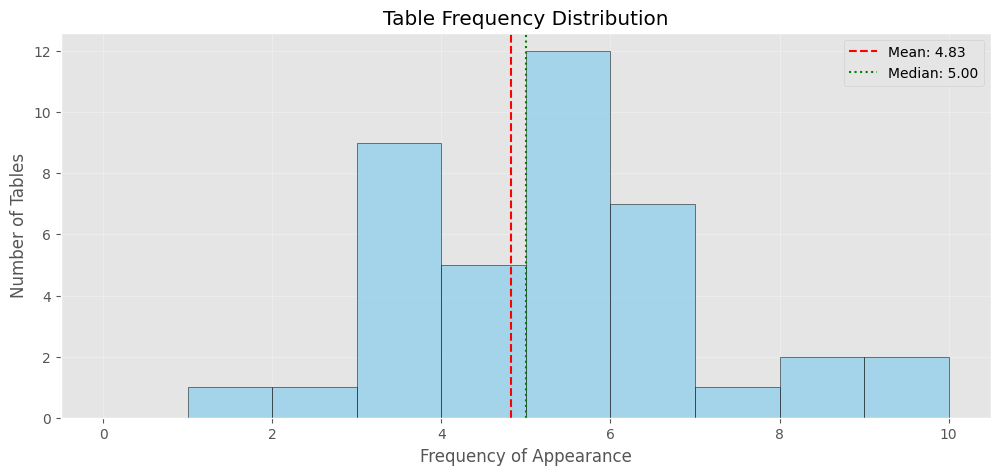

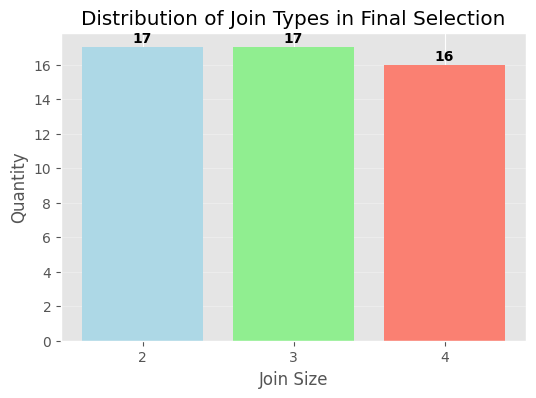

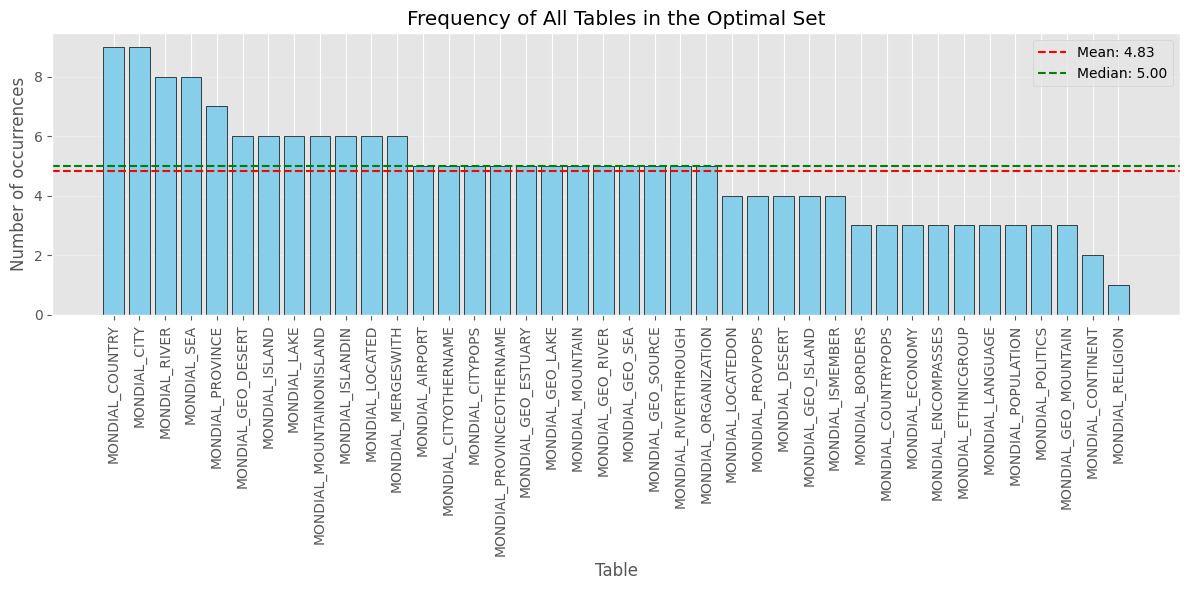

Saved optimal join combinations to mondial/optimal_join_combinations.csv


In [14]:
# Now we run everything

def run_full_process(joins, min_n=50):
    # 1) build schema graph
    schema_graph = build_schema_graph(joins)
    all_tables = list(schema_graph.nodes())
    
    # 2) generate all possible combinations
    combos_by_type= prepare_all_combinations(joins, max_size=4)
    
    # 3) select balanced combinations
    selected, table_freq, covered= select_balanced_combinations(
        combos_by_type, 
        all_tables, 
        min_n=min_n,
        coverage_first=True  # priorize 100% coverage
    )
    
    # 4) show and plot
    summarize_and_plot_results(selected, table_freq, all_tables)
    plot_all_table_frequencies(table_freq, "Frequency of All Tables in the Optimal Set")
    save_optimal_join_combinations(selected)


run_full_process(joins, min_n=50)

Above you can see that we got:

1. 100% coverage of schema
2. balanced join types
3. balanced tables representation

So now we have an algorithm to find n join combinations over all possible joins in our schema, so now we can go to next notebook to see how we used it to generate our dialogues dataset.